In [73]:
import pandas as pd
import json, os, sqlite3, math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

with open('cfg.json') as json_file:
    cfg = json.load(json_file)

In [51]:
# Get kmeans cluster
kmeans_cluster = pd.read_csv('kmeans.csv', index_col=0)
all_pts = kmeans_cluster
kmeans_cluster = kmeans[kmeans['cluster']==1]
kmeans_cluster

,mrn_csn_pair,cluster
22,"(2309, 2097)",1
27,"(2789, 1574)",1
33,"(662, 2701)",1
35,"(2221, 1147)",1
45,"(352, 14)",1
...,...,...
1444,"(1673, 122)",1
1451,"(1895, 597)",1
1462,"(1391, 818)",1
1468,"(2574, 2872)",1


In [52]:
# Get agg cluster
agg_cluster = pd.read_csv('agglomerative.csv', index_col=0)
agg_cluster = agg_cluster[agg_cluster['cluster']==2]
agg_cluster

,mrn_csn_pair,cluster
27,"(2789, 1574)",2
33,"(662, 2701)",2
35,"(2221, 1147)",2
45,"(352, 14)",2
58,"(128, 1144)",2
...,...,...
1443,"(756, 907)",2
1444,"(1673, 122)",2
1462,"(1391, 818)",2
1468,"(2574, 2872)",2


In [55]:
# Get intersection
merged = pd.merge(kmeans_cluster, agg_cluster, how='inner', on='mrn_csn_pair')
merged = merged['mrn_csn_pair'].tolist()

In [61]:
all_pts['cluster']=0
all_pts['cluster'] = all_pts['mrn_csn_pair'].apply(lambda x: 1 if x in merged else 0)
all_pts['cluster'].value_counts()

0    1316
1     154
Name: cluster, dtype: int64

In [64]:
# Get time series
measures_to_get = ['pulse', 'sbp', 'dbp', 'temp', 'pulse_ox']
def getTS(dat_conn):
    merged_dir = os.path.join(cfg['WORKING_DATA_DIR'], 'Preprocessed/Working/Merged.db')
    merged_conn = sqlite3.connect(merged_dir)
    dat_ts = pd.read_sql('SELECT * FROM timeseries_instantaneous WHERE timestamp >= 0 AND timestamp <= 1440',
                         merged_conn)
    dat_ts = pd.merge(dat_ts, dat_conn, how='inner', on='mrn_csn_pair')

    mrn_csns = dat_ts['mrn_csn_pair'].unique()
    time_indices = range(0, int(1440 / 5))
    n = len(mrn_csns)

    timeseries = np.empty((n, len(time_indices) + 1, len(measures_to_get)))
    for m, f in enumerate(measures_to_get):
        f_dat = dat_ts[dat_ts['measure'] == f]
        for mrn_csns_n, mcp in enumerate(mrn_csns):
            ts = pd.Series(np.NaN, index=time_indices)
            dat_sub = f_dat[f_dat['mrn_csn_pair'] == mcp].reset_index(drop=True)

            ts.loc[0] = dat_sub['value'][0]
            for i, r in dat_sub.iterrows():
                ts.loc[round(r['timestamp'] / 5)] = r['value']
            ts = ts.interpolate('pad')
            for ti, t in enumerate(ts):
                timeseries[mrn_csns_n, ti, m] = t
    return timeseries
timeseries = getTS(all_pts)

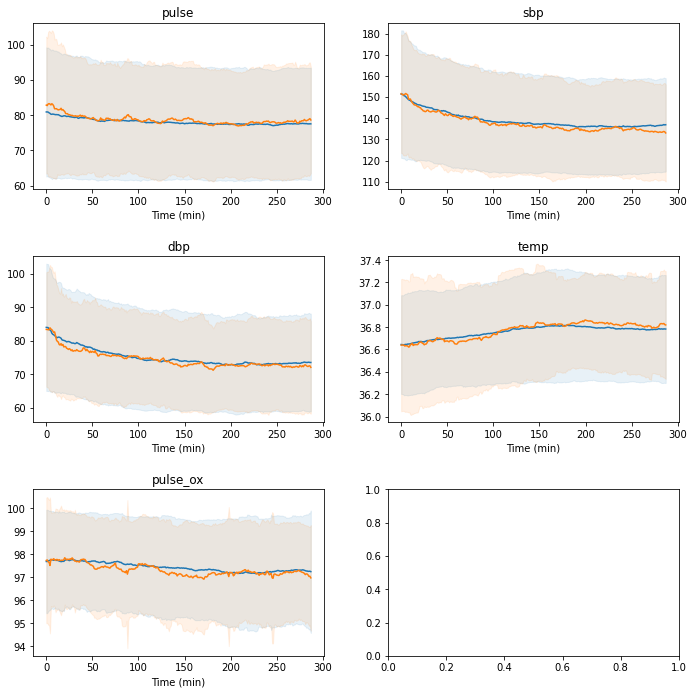

In [65]:
def getTSplot(n_clusters, cluster):
    ncol = 2
    fig, ax = plt.subplots(math.ceil(len(measures_to_get) / ncol), ncol, figsize=(10, 10))
    for meas_i, meas in enumerate(measures_to_get):
        colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
                  'tab:olive', 'tab:cyan']
        for i in range(n_clusters):
            mn = np.mean(timeseries[cluster == i, :-1, meas_i], axis=0)
            std = timeseries[cluster == i, :-1, meas_i].std(axis=0)
            ax[meas_i // ncol, meas_i % ncol].fill_between(range(len(std)), mn - 1 * std, mn + 1 * std, color=colors[i],
                                                           alpha=0.1)
            ax[meas_i // ncol, meas_i % ncol].plot(mn, color=colors[i])

        ax[meas_i // ncol, meas_i % ncol].set_title(meas)
        ax[meas_i // ncol, meas_i % ncol].set_xlabel('Time (min)')
    fig.tight_layout(pad=2)
    plt.show()
getTSplot(2,all_pts['cluster'])

In [111]:
# Get ts freshed data
ts_freshed_dir = os.path.join(cfg['WORKING_DATA_DIR'], 'Preprocessed/Working/Complete_updated.csv')
dat = pd.read_csv(ts_freshed_dir, index_col=0)
dat = pd.merge(dat, all_pts, how='inner', on='mrn_csn_pair').drop(columns=['LOS'])
dat

,mrn_csn_pair,ALBUMIN__median,ALBUMIN__mean,ALBUMIN__maximum,ALBUMIN__minimum,ALBUMIN__benford_correlation,ALBUMIN__quantile__q_0.1,ALBUMIN__quantile__q_0.2,ALBUMIN__quantile__q_0.3,ALBUMIN__quantile__q_0.4,...,hx_htn,hx_kidney_disease,hx_other,pl_afib,pl_cancer,pl_diabetes,pl_heart_failure,pl_htn,pl_kidney_disease,cluster
0,"(10, 2913)",3.90,3.90,3.9,3.9,0.062915,3.90,3.90,3.90,3.90,...,0,0,4,0,0,1,0,1,0,0
1,"(10, 2953)",3.70,3.70,3.8,3.6,0.062915,3.65,3.70,3.70,3.70,...,0,0,0,0,0,1,0,1,0,1
2,"(1001, 2708)",4.20,4.20,4.2,4.2,-0.064614,4.20,4.20,4.20,4.20,...,0,0,0,0,0,0,0,0,0,0
3,"(1002, 3238)",4.40,4.40,4.4,4.4,-0.064614,4.40,4.40,4.40,4.40,...,0,0,0,0,1,0,0,0,0,0
4,"(1004, 1204)",3.45,3.45,3.6,3.3,0.062915,3.33,3.36,3.39,3.42,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,"(995, 1464)",5.10,5.10,5.1,5.1,-0.145280,5.10,5.10,5.10,5.10,...,1,0,4,0,0,0,0,1,1,0
1466,"(995, 1520)",3.70,3.70,3.8,3.6,0.062915,3.65,3.70,3.70,3.70,...,0,0,0,0,0,0,0,1,1,1
1467,"(996, 1653)",3.70,3.70,3.8,3.6,0.062915,3.65,3.70,3.70,3.70,...,0,0,0,0,0,0,0,1,1,0
1468,"(998, 3015)",3.70,3.70,3.8,3.6,0.062915,3.65,3.70,3.70,3.70,...,0,0,0,1,0,1,0,1,0,0


In [156]:
from scipy.stats import ttest_ind as tt
from scipy.stats import chisquare as cs

tests = []

for c in dat.columns[1:-1]:
    t = None
    if c[:3] == 'hx_' or c[:3] == 'pl_':
        t = cs([dat[dat['cluster']==0][c].sum(), dat[dat['cluster']==1][c].sum()])
    else:
        pass
        t = tt(dat[dat['cluster']==0][c],dat[dat['cluster']==1][c])
        
    tests.append([c, t.statistic, t.pvalue])

NameError: name 'test' is not defined

In [168]:
results = pd.DataFrame(tests)
results.columns = ['measure', 'statistic', 'p']
sigres = results[results['p'] <= .05/results.shape[0]].sort_values('statistic', ascending=False)
sigres.to_csv('sigres.csv')